# Case 2 - Diabetic Retinopathy Analysis
Mikko Peltola
<br>
Last edited: 28.2.2018
<br>
Cognitive Systems for Health Technology Applications
<br>
<a href="https://www.metropolia.fi/en">Helsinki Metropolia University of Applied Sciences</a>

---
## 1. Objectives

The primary objective of this assignment to create a convolutional neural network capable of detecting diabetic retinopathy in predicting diabetic retinopathy in people with diabetes. This will be done by classifying images into binary categories: non-symptomatic and symptomatic, with the symptomatic category containing every degree of severity. The symptomatic eye images are cases in which hard exudates, inter-retinal haemorrhaging or microaneyrysms have been detected by medical professionals.
<br><br>
If a reliable model were to be created, it could serve as a detector, an early warning system or at least speed up the diagnosis process.

---
## 2. Required libraries

In [17]:
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image

import os, random, sys, time


#### Version information

In [3]:
print("python: {0}".format(sys.version))
print("numpy: {0}".format(np.__version__))
print("sklearn: {0}".format(sklearn.__version__))
print("matplotlib: {0}".format(matplotlib.__version__))
print("keras: {0}".format(keras.__version__))

python: 3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 14:34:30) [MSC v.1900 64 bit (AMD64)]
numpy: 1.13.3
sklearn: 0.19.1
matplotlib: 2.1.2
keras: 2.1.3


---
## 3. Data description
The data is split into three sets: train, validation and test, each having a split of symptomatic and non-symptomatic images. The dataset used in this study is a curated version of the original retinopathy-dataset provided by [*Nomikxyz*](https://github.com/Nomikxyz/retinopathy-dataset).
<br><br>
The dataset is split as follows:
- Train
    - Total images: 1238
    - Symptomatic: 358 (28.87%)
    - Non-symptomatic: 882 (71.13%)
- Validation
    - Total images: 412
    - Symptomatic: 120 (28.99%)
    - Non-symptomatic: 294 (71.01%)
- Test
    - Total images: 413
    - Symptomatic: 120 (28.92%)
    - Non-symptomatic: 295 (71.08%)

### Sample images
Two random sample images, one symptomatic and one non-symptomatic, are previewed.

Text(0.5,1,'Test, non-symptomatic')

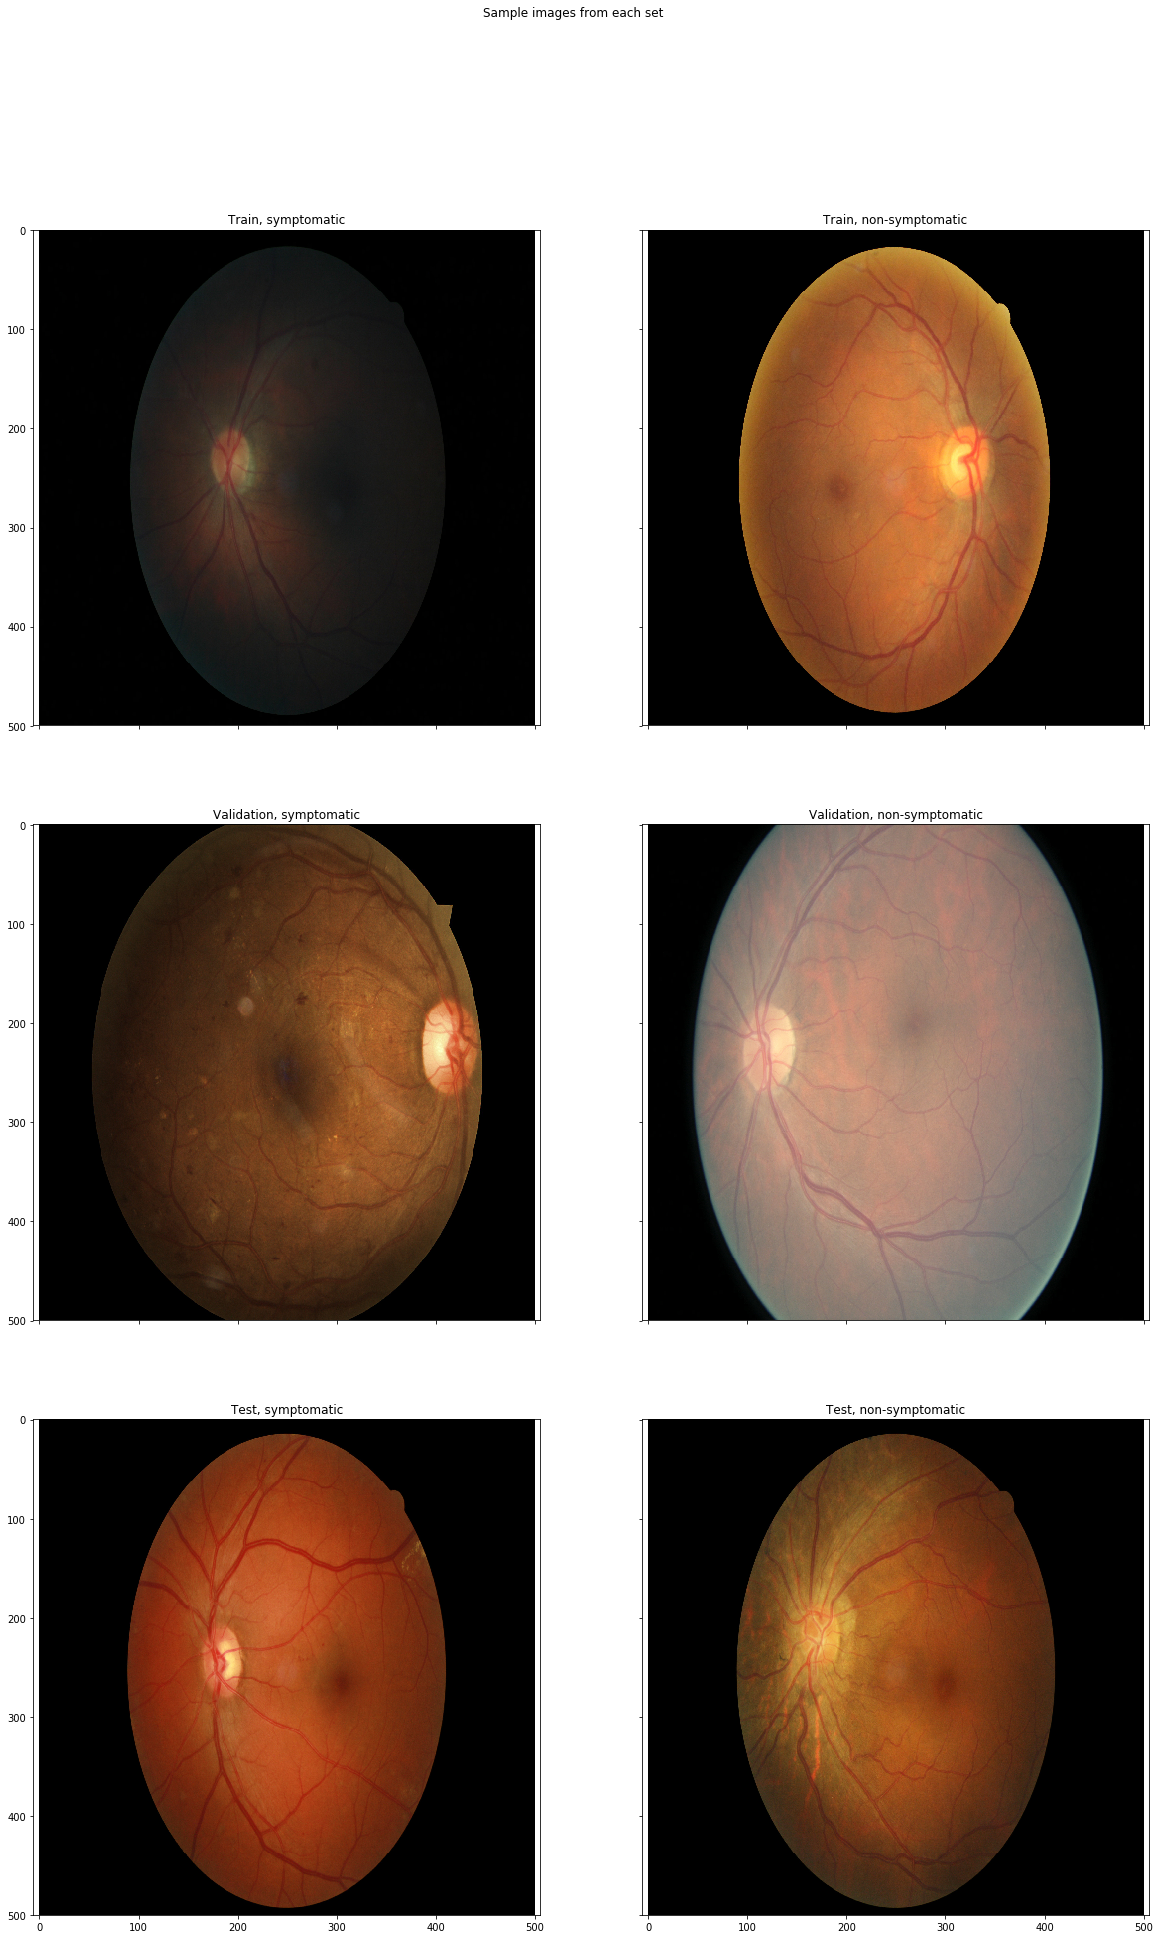

In [4]:
path_train_sym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\train\\symptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\train\\symptoms\\"))
path_train_nosym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\train\\nosymptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\train\\nosymptoms\\"))

path_val_sym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\validation\\symptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\validation\\symptoms\\"))
path_val_nosym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\validation\\nosymptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\validation\\nosymptoms\\"))

path_test_sym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\test\\symptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\test\\symptoms\\"))
path_test_nosym = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\test\\nosymptoms\\" + random.choice(os.listdir("C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\test\\nosymptoms\\"))

img1 = image.load_img(path_train_sym, grayscale=False, target_size=(500, 500))
img2 = image.load_img(path_train_nosym, grayscale=False, target_size=(500, 500))
img3 = image.load_img(path_val_sym, grayscale=False, target_size=(500, 500))
img4 = image.load_img(path_val_nosym, grayscale=False, target_size=(500, 500))
img5 = image.load_img(path_test_sym, grayscale=False, target_size=(500, 500))
img6 = image.load_img(path_test_nosym, grayscale=False, target_size=(500, 500))

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(20, 31))
f.suptitle("Sample images from each set")

ax1.imshow(img1)
ax1.set_title("Train, symptomatic")

ax2.imshow(img2)
ax2.set_title("Train, non-symptomatic")

ax3.imshow(img3)
ax3.set_title("Validation, symptomatic")

ax4.imshow(img4)
ax4.set_title("Validation, non-symptomatic")

ax5.imshow(img5)
ax5.set_title("Test, symptomatic")

ax6.imshow(img6)
ax6.set_title("Test, non-symptomatic")

---
## 4. Generators
A script for dividing the dataset into distinct directories for easy use with Keras' ImageDataGenerator was provided by our instructor, [Sakari Lukkarinen](https://github.com/sakluk).
<br><br>
After defining the paths to relevant directories, three ImageDataGenerators are created:
- train_datagen: rescaling of images, horizontal and vertical flips
- validation_datagen: rescales the images
- test_datagen: rescales the images

No other transformations were used in the training generator, since real-life retinal images should not diverge too much from our training cases. Also, even the size of our curated dataset is most probably large enough for us to achieve at least a limited degree of success without further image augmentation. For now, this will do. The validation_datagen and test_datagen are identical and a single generator could be used for both, but for clarity's sake separate generators are created for both validation and test sets. 

In [5]:
train_path = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\train"
validation_path = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\validation"
test_path = "C:\\Users\\micromikko\\AnacondaProjects\\data\\case2_data\\test"

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(150, 150), batch_size=30, class_mode="binary")
validation_generator = validation_datagen.flow_from_directory(validation_path, target_size=(150, 150), batch_size=30, class_mode="binary")
test_generator = test_datagen.flow_from_directory(test_path, target_size=(150, 150), batch_size=30, class_mode="binary")

Found 1238 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


---
## 5. Model

### 5.1. Model description
The training of the model was expected to take a long time when working with a laptop, which is why checkpoints were used in training. This allows the interruptions of the model's training phase, as the model was evaluated after each epoch. If the freshly trained model was better than the previous one, it was saved to disk.
<br><br>
The original code used in training the model is displayed below for demonstrative purposes, and it is now commented out.

In [6]:
# === Creating the model ===
# model = keras.models.Sequential()

# model.add(layers.Conv2D(16, (3, 3), activation="relu", input_shape=(150, 150, 3)))
# model.add(layers.Conv2D(16, (3, 3), activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

# model.add(layers.Conv2D(32, (3, 3), activation="relu"))
# model.add(layers.Conv2D(32, (3, 3), activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

# model.add(layers.Flatten())

# model.add(layers.Dense(32, activation="relu"))
# model.add(layers.Dense(64, activation="relu"))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(1, activation="sigmoid"))

# === Model summary ===
# model.summary()

# === Compiling model ===
# model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# === Defining the checkpointing system ===
# filepath = "C:\\Users\\micromikko\\AnacondaProjects\\models\\case2_test_best\\case2-{epoch:02d}-{val_loss:.2f}.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# === Training the model ===
# start = time.time()
# model_history = model.fit_generator(train_generator, steps_per_epoch=32, epochs=3, validation_data=validation_generator, validation_steps=20, verbose=1, callbacks=[checkpoint])
# end = time.time()
# total = (end - start) / 60

# print("elapsed time:", total)

### 5.2 Loading pretrained model
The model loaded is the one described in the cell above. It was trained for 119 epochs over roughly 9 hours. The training peaked at epoch 89, and thus that particular model was selected for our study. This method unfortunately denies us access to the history statistics of the training process, as data from all but the best model is lost. In hindsight, for future projects collecting the training history would be beneficial.
<br><br>
Our selected model reached a validation accuracy of 0.83, while the training accuracy was surprisingly slightly lower at 0.78. As we are slightly underfitting, this probably means that our model capacity could be  larger to better capture the complexities of the task at hand. For this, I would probably look into renting server time from any number of companies that provide the service.
<br><br>
The summary of the model is printed below.

In [7]:
model = load_model("C:\\Users\\micromikko\\AnacondaProjects\\models\\case2_test_best\\case2-89-0.83.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 34, 32)        0         
__________

---
## 6. Evaluation
The model is evaluated with the so far untouched test set. With a loss of 0.5201 and accuracy of 0.7878, the model's performance does not differ that much from a pure guessing situation. The percentage increase of a correct classification of the model to always guessing the more likely situation (non-symptomatic) is barely under 10%.

In [8]:
evaluation = model.evaluate_generator(test_generator, steps=np.ceil(413 / 14))
print("loss: {0}\naccuracy:{1}".format(evaluation[0], evaluation[1]))

loss: 0.5379772627595855
accuracy:0.7799097070844663


In [25]:
always_no = 294 / (294+119)
percentage_increase = (evaluation[1] - always_no) / always_no
print("always no:", always_no)
print("percentage increase:", percentage_increase)

always no: 0.711864406779661
percentage increase: 0.0955874456663


### Predicting results
Ground truth and predictions are gathered and formatted in a 1D array for further use.

In [11]:
ground_truth = np.zeros(413);
test_predictions = np.zeros(413);
binary_test_predictions = np.zeros(413);

test_samples = 413;

i = 0;

for current_batch, labels_batch in test_generator:
	predicts_batch = model.predict(current_batch)
	L = labels_batch.shape[0]
	index = range(i, i + L)
	ground_truth[index] = labels_batch.ravel()
	test_predictions[index] = predicts_batch.ravel()
	i = i + L
	if i >= test_samples:
		break

### ROC curve
The ROC curve is plotted to allow us to examine how well we are able to distinguish symptomatic and non-symptomatic cases. The larger the area under the curve, the better the model is. The second plot allows us to select the optimal threshold value, which is around 0.38 in our case, for further analysis.

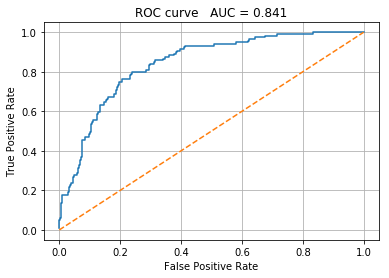

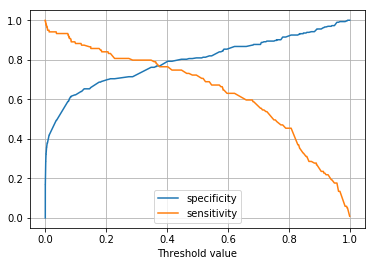

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(ground_truth, test_predictions)
auc = metrics.roc_auc_score(ground_truth, test_predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve   AUC = {:.3f}".format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label="specificity")
plt.plot(thresholds, tpr, label="sensitivity")
plt.grid()
plt.legend()
plt.xlabel("Threshold value")
plt.show()

### Further analysis
Since our class distribution is very uneven (less than a third of our samples fall in the symptomatic class), the f1 score is a better metric to determine whether or not our model is any good than simply looking at precision and recall, as it is a weighted average of both metrics.
<br><br>
In this case the f1 score conforms to our accuracy metric of roughly 0.78, and the goodness of the model is debatable. 

In [22]:
print(metrics.classification_report(ground_truth, test_predictions > 0.38, labels=[1.0, 0.0], target_names=["Symptomatic", "Non-symptomatic"]))

                 precision    recall  f1-score   support

    Symptomatic       0.58      0.76      0.66       119
Non-symptomatic       0.89      0.77      0.83       294

    avg / total       0.80      0.77      0.78       413



## 7. Conclusion
The model created here is barely better (only a 10% percentual increase) than a straight forward strategy of going with the likely case, which is non-symptomatic.
<br><br>
Something that could have been done is experimentation with various brightness and contrast permutations on the images, and perhaps experimentating with grayscale conversions.
<br><br>
A real constriction on the exercise from my part is the lack of better hardware for crunching larger models, which would at least open up some possibilities. The decision to limit the images to 150x150 pixels was largely due to these very constraints, as was the relative shallowness of the models convolutional layers.
<br><br>
For future cases a relatively inexpensive cloud platform for computing larger models would be ideal.
<br><br>
I would conclude by stating that the primary goal of creating a viable model for detecting signs of diabetic retinopathy was not achieved. A secondsry objective of learning more about the practical uses of convolutional networks and analysis has been achieved.